In [1]:
!pip install git+https://github.com/salaniz/pycocoevalcap
!pip install tqdm

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-2y4ze6kj
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-2y4ze6kj
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=cca767c62c5adc9dfa8de81cf668f532461ab608585d8fede134f8536fed50a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-0x70aysq/wheels/d2/1f/44/6485e566f8ae3d42b56e7c05fd50a3bbb70a50b0e6e7c55212
Successfully built pycocoevalcap
/kaggle/input
/kaggle/input/flickr8k
/kaggle/input/flickr8k/Images


<!-- 1. Gather data, determine the method of data collection and provenance of the data
2. Identify a Deep Learning Problem
3. Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data
4. Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions -->

# Database Introduction and Provenance
In this project, I will train a deep learning model on Kaggle. I used flickr8k database, which is on Kaggle, consisting of 8,000 images that are each image with 5 different captions which provide clear descriptions of the salient entities and events.

# Identify a Deep Learning Problem
For this project, I want to solve the image caption problem. Image Captioning is a vision-language generation problem, which means I need to generate a description for an image.

# Hardware
- Kaggle GPU T4 *2 
- Training time: about 2 hours three model

In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from collections import defaultdict
import os
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import layers, Model

##########
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider


In [3]:
image_path = '/kaggle/input/flickr8k/Images/'
caption_path = '/kaggle/input/flickr8k/'

df = pd.read_csv(caption_path + 'captions.txt', names=['image', 'caption'], encoding='utf-8')
df = df.sort_values(by=["image", "caption"])

print(f'There are {len(df)} images')
print(f'image_path {image_path}')
df.head()


There are 40456 images
image_path /kaggle/input/flickr8k/Images/


,image,caption
1,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
5,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# EDA
For caption, I showed some EDA to get more understanding about the dataset.
Some words appear more frequency than others, but some words do not. 
It indicates that maybe we should do some data cleaning or add others features for our database to make the model better.

I also check 5 caption and image to get more understanding about the dataset.

In [4]:
def preprocess_caption(char):
    char = char.lower()
    char = re.sub('[^a-z ]+', '', char) 
    char = re.sub('\s+', ' ', char).strip()
    return char

df['clean_caption'] = df['caption'].apply(preprocess_caption)
df['tokens'] = df['clean_caption'].apply(lambda x: x.split())

# word amount
df['length'] = df['tokens'].apply(len)
avg_len = df['length'].mean()

print("Average word count:", avg_len)
print("Max word count:", df['length'].max())
print("Min word count:", df['length'].min())

Average word count: 10.785520071188452
Max word count: 35
Min word count: 1


Vocabulary Size: 8779


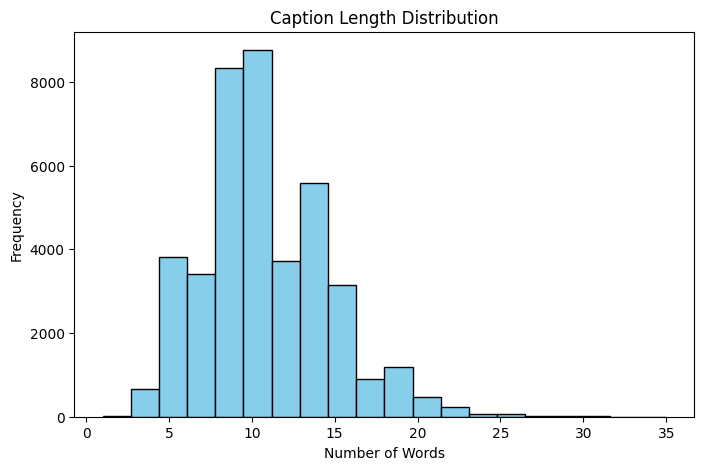

In [5]:
# check word frequency
all_words = [word for tokens in df['tokens'] for word in tokens]

vocab = set(all_words)
vocab_size = len(vocab)

print("Vocabulary Size:", vocab_size)
word_freq = Counter(all_words)

plt.figure(figsize=(8,5))
plt.hist(df['length'], bins=20, color='skyblue', edgecolor='black')
plt.title("Caption Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


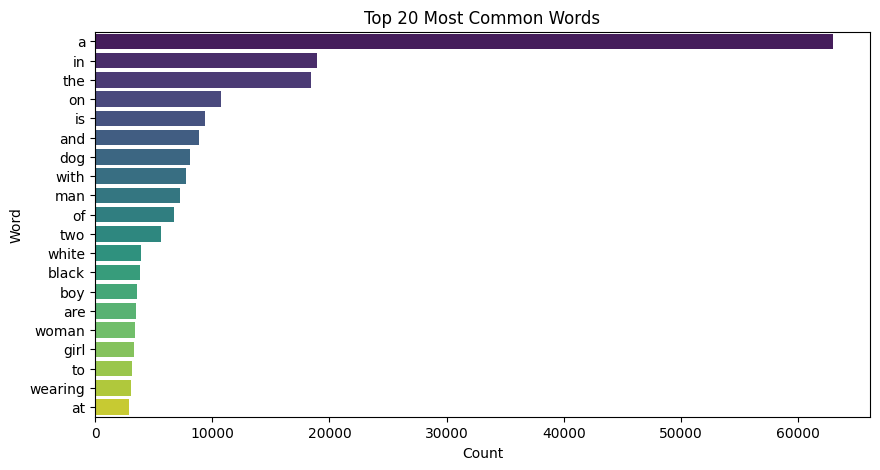

In [6]:
top_20 = word_freq.most_common(20)

words = [w for w, c in top_20]
counts = [c for w, c in top_20]

plt.figure(figsize=(10,5))
sns.barplot(x=counts, y=words, palette="viridis")
plt.title("Top 20 Most Common Words")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

========== Image: 1000268201_693b08cb0e.jpg ==========


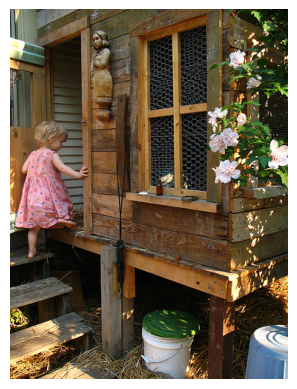

Caption 1: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption 2: A girl going into a wooden building .
Caption 3: A little girl climbing into a wooden playhouse .
Caption 4: A little girl climbing the stairs to her playhouse .
Caption 5: A little girl in a pink dress going into a wooden cabin .


========== Image: 1001773457_577c3a7d70.jpg ==========


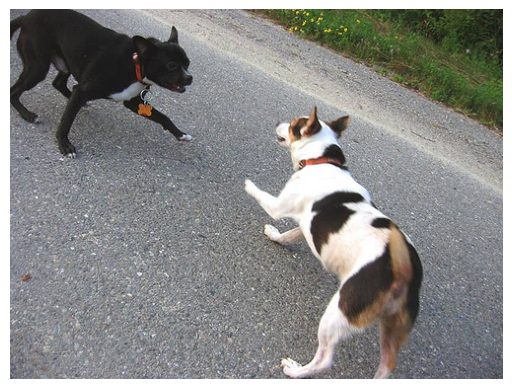

Caption 1: A black dog and a spotted dog are fighting
Caption 2: A black dog and a tri-colored dog playing with each other on the road .
Caption 3: A black dog and a white dog with brown spots are staring at each other in the street .
Caption 4: Two dogs of different breeds looking at each other on the road .
Caption 5: Two dogs on pavement moving toward each other .


========== Image: 1002674143_1b742ab4b8.jpg ==========


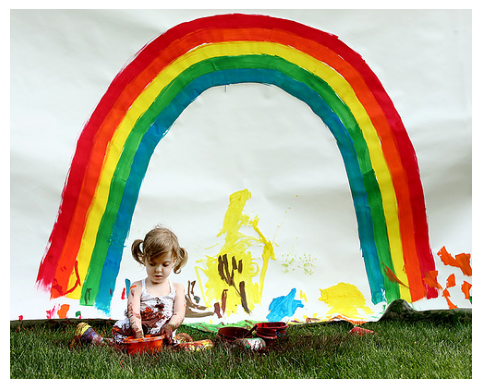

Caption 1: A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
Caption 2: A little girl is sitting in front of a large painted rainbow .
Caption 3: A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
Caption 4: There is a girl with pigtails sitting in front of a rainbow painting .
Caption 5: Young girl with pigtails painting outside in the grass .


========== Image: 1003163366_44323f5815.jpg ==========


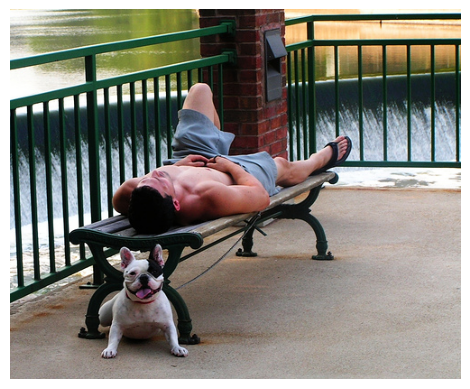

Caption 1: A man lays on a bench while his dog sits by him .
Caption 2: A man lays on the bench to which a white dog is also tied .
Caption 3: A shirtless man lies on a park bench with his dog .
Caption 4: a man sleeping on a bench outside with a white and black dog sitting next to him .
Caption 5: man laying on bench holding leash of dog sitting on ground




In [ ]:
sample_images = df['image'].unique()[:4] 

for img_name in sample_images:
    img = Image.open(os.path.join(image_path, img_name))
    
    print("Image:", img_name)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    captions = df[df['image'] == img_name]['caption'].tolist()
    for i, c in enumerate(captions):
        print(f"Caption {i+1}: {c}")
    print("\n")

# Data Cleaning
I did the following data cleaning: 
- Remove shorter captions to ensure meaningful training input
- Remove the words that appear only once to reduce vocabulary noise
- Added a special <unk> token to handle unseen word during training and inference
- Converted captions to integer sequences and padded them to a fixed maximum length for uniform model input
- Created index-to-word mapping to enable caption decoding during inference 


In [ ]:
# exclude the rarely shown word to our training model
min_freq = 2 
word_freq = Counter([w for tokens in df['tokens'] for w in tokens])

# only keep the word frequently shown
frequent_words = {w for w, c in word_freq.items() if c >= min_freq}
print("frequent_words count:", len(frequent_words))

df['tokens_filtered'] = df['tokens'].apply(
    lambda toks: [w for w in toks if w in frequent_words]
)

# remove more shorter caption 
df['len_filtered'] = df['tokens_filtered'].apply(len)
print("before removing shorter caption count:", len(df))

df = df[df['len_filtered'] >= 2].reset_index(drop=True)
print("after removing shorter caption count:", len(df))

# use 'startseq' / 'endseq' for marking start/end
df['tokens_with_special'] = df['tokens_filtered'].apply(
    lambda toks: ['startseq'] + toks + ['endseq']
)

# token list convert to string, for tokenizer
final_texts = df['tokens_with_special'].apply(lambda toks: " ".join(toks)).tolist()

print("Check processed caption:")
print(final_texts[0])

# create oov token 
# vocab_size is 5000 ~ 8000
target_vocab_size = 8000

tokenizer = Tokenizer(
    num_words=target_vocab_size,
    oov_token="<unk>",
    filters='!"#$%&()*+,-./:;=?@[\]^_`{|}~\t\n'
)

tokenizer.fit_on_texts(final_texts)

full_vocab_size = len(tokenizer.word_index) + 1  # +1 for padding=0
print("Tokenizer vocabulary size:", full_vocab_size)

vocab_size = min(target_vocab_size, full_vocab_size)
print("vocab_size for training:", vocab_size)

sequences = tokenizer.texts_to_sequences(final_texts)

print("Check tokenized sequence:")
print(sequences[0])

max_len = max(len(seq) for seq in sequences)
print("Caption max length:", max_len)

cap_padded = pad_sequences(
    sequences,
    maxlen=max_len,
    padding='post',  
    truncating='post' 
)

print("Padded captions shape:", cap_padded.shape)

# index -> word mapping
# word -> index
word_index = tokenizer.word_index           
# index -> word
index_word = {i: w for w, i in word_index.items()}  

print("index 1 -> word:", index_word.get(1))
print("index 2 -> word", index_word.get(2))

img_paths = df['image'].apply(lambda x: os.path.join(image_path, x)).values

print(f'There are {len(df)} images after cleaning')
print(f'image_path {image_path}')
print(f'img_paths {img_paths[0]}, count: {len(img_paths)}')

frequent_words count: 5198
before removing shorter caption count: 40456
after removing shorter caption count: 40451
Check processed caption:
startseq a child in a pink dress is climbing up a set of stairs in an way endseq
Tokenizer vocabulary size: 5202
vocab_size for training: 5202
Check tokenized sequence:
[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 694, 4]
Caption max length: 37
Padded captions shape: (40451, 37)
index 1 -> word: <unk>
index 2 -> word a
There are 40451 images after cleaning
image_path /kaggle/input/flickr8k/Images/
img_paths /kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg, count: 40451


# Create Dataset

In [ ]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32)
    return img
    
caption_in  = cap_padded[:, :-1]
caption_out = cap_padded[:, 1:]
max_len = caption_in.shape[1]

print("caption_in shape:", caption_in.shape)
print("caption_out shape:", caption_out.shape)
print("max_len:", max_len)

# split dataset
img_train, img_val, cap_in_train, cap_in_val, cap_out_train, cap_out_val = train_test_split(
    img_paths, caption_in, caption_out, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

print("Train size:", len(img_train))
print("Val size:", len(img_val))

# tensor slice 
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_in_train, cap_out_train))

def map_func(path, cap_in, cap_out):
    img = load_image(path)
    return (img, cap_in), cap_out

train_dataset = train_dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(512).batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((img_val, cap_in_val, cap_out_val))
val_dataset = val_dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)


for (x, y) in train_dataset.take(1):
    img_batch, cap_in_batch = x
    cap_out_batch = y
    print("img_batch.shape     :", img_batch.shape)
    print("cap_in_batch.shape  :", cap_in_batch.shape)
    print("cap_out_batch.shape :", cap_out_batch.shape)
    break

caption_in shape: (40451, 36)
caption_out shape: (40451, 36)
max_len: 36
Train size: 32360
Val size: 8091


I0000 00:00:1764473667.671378     678 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764473667.672063     678 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


img_batch.shape     : (64, 224, 224, 3)
cap_in_batch.shape  : (64, 36)
cap_out_batch.shape : (64, 36)


# Model Design
In this project, I used one shared encoder and compare three decoders. The encoder is responsible for extracting visual feature from images.
Then I varied three decoders and compare how different sequence-generation models affect caption quality.

## Encoder
I used EfficientNetB0 to extract 7×7×1280 feature maps from the input image, reshapes them into 49 visual tokens, and convert each token to a 256-dimensional embedding for the caption decoder.

In [ ]:
IMAGE_SIZE = (224, 224)

'''
try two cnn_encoder
1. EfficientNetB0
2. ResNet50
'''
def build_cnn_encoder(
    encoder_type="efficientnet", 
    d_model=256,
    trainable=False
):
    """
    inputs:  (batch, 224, 224, 3)
    outputs: (batch, num_patches, d_model)
    """
    img_input = layers.Input(shape=(*IMAGE_SIZE, 3), name="image")

    if encoder_type.lower() == "efficientnet":
        base_cnn = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights="imagenet"
        )
        preprocess = tf.keras.applications.efficientnet.preprocess_input
        encoder_name = "efficientnetb0_encoder"

    elif encoder_type.lower() == "resnet50":
        base_cnn = tf.keras.applications.ResNet50(
            include_top=False,
            weights="imagenet"
        )
        preprocess = tf.keras.applications.resnet50.preprocess_input
        encoder_name = "resnet50_encoder"

    else:
        raise ValueError("encoder_type 必須是 'efficientnet' 或 'resnet50'")

    # enable fine-tune CNN
    base_cnn.trainable = trainable

    # backbone format
    x = preprocess(img_input)

    # feature map shape => (batch, H, W, C)
    feature_map = base_cnn(x, training=False)

    # (batch, 7, 7, C) -> (batch, 49, C)
    spatial_features = layers.Reshape((-1, feature_map.shape[-1]))(feature_map)

    # dimension d_model
    encoded = layers.Dense(d_model, activation="relu")(spatial_features)

    encoder_model = Model(inputs=img_input, outputs=encoded, name=encoder_name)
    return encoder_model


In [ ]:
# I use EfficientNetB0 encoder
encoder = build_cnn_encoder(
    encoder_type="efficientnet",
    d_model=256,
    trainable=False # no fine tune
)

encoder.summary()


Model: "efficientnetb0_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 49, 1280)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 49, 256)        │       327,936 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,507 (16.70 MB)

 Trainable params: 327,936 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Decoder

### 1-layer LSTM Decoder
The 1-layer LSTM decoder is to generate vocabulary logits for image caption generation. 
Image features provide the initial hidden states, the decoder generatea each word step-by-step and produce a complete caption aligned with the visual content.

### 2-layer LSTM Decoder
A second stacked LSTM uses the sequence representation, enabling deeper language modeling before generating vocabulary logits for each word in the caption.

### Transformer Decoder
The Transformer decoder embeds caption tokens with positional encoding and processes them through self-attention and cross-attention layers. It attends to the 49 visual tokens extracted by the encoder and generates vocabulary logits for each time step to produce the final caption.


In [ ]:
d_model = 256

def build_lstm_decoder_model_1layer(
    encoder,
    vocab_size,
    max_len,
    d_model=256
):
    # Encoder
    # (B, 224, 224, 3)
    image_input = encoder.input                         
    # (B, 49, d_model)
    enc_output = encoder.output                       

    # 49 tokens to a image vector 
    img_feat = layers.GlobalAveragePooling1D()(enc_output)  

    # LSTM init hidden cell state
    h0 = layers.Dense(d_model, activation='tanh')(img_feat)
    c0 = layers.Dense(d_model, activation='tanh')(img_feat)

    # Caption input
    caption_input = layers.Input(shape=(max_len,), name="caption_in")

    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=d_model,
        mask_zero=True,        
        name="word_embedding"
    )(caption_input)             

    # 1 LSTM
    x = layers.LSTM(
        d_model,
        return_sequences=True,
        name="lstm_layer_1"
    )(x, initial_state=[h0, c0])  # (B, T, d_model)

    # vocab time base
    logits = layers.Dense(vocab_size, name="output_dense")(x)  # (B, T, vocab_size)

    model = Model(
        inputs=[image_input, caption_input],
        outputs=logits,
        name="cnn_1lstm_caption"
    )
    return model

model_lstm_1 = build_lstm_decoder_model_1layer(
    encoder=encoder,
    vocab_size=vocab_size,
    max_len=max_len,
    d_model=d_model
)

model_lstm_1.summary()


Model: "cnn_1lstm_caption"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image[0][0]       │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 1280)  │          0 │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 49, 256)   │    327,936 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_in          │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ dense[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 36, 256)   │  1,331,712 │ caption_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 36, 256)   │    525,312 │ word_embedding[0… │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 36, 5202)  │  1,336,914 │ lstm_layer_1[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,703,029 (29.38 MB)

 Trainable params: 3,653,458 (13.94 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
def build_lstm_decoder_model_2layer(
    encoder,
    vocab_size,
    max_len,
    d_model=256
):
    image_input = encoder.input
    enc_output = encoder.output

    img_feat = layers.GlobalAveragePooling1D()(enc_output)
    h0 = layers.Dense(d_model, activation='tanh')(img_feat)
    c0 = layers.Dense(d_model, activation='tanh')(img_feat)

    caption_input = layers.Input(shape=(max_len,), name="caption_in")

    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=d_model,
        mask_zero=True,
        name="word_embedding"
    )(caption_input)

    # 1 LSTM <= init state
    x = layers.LSTM(
        d_model,
        return_sequences=True,
        name="lstm_layer_1"
    )(x, initial_state=[h0, c0])

    # 2 LSTM <= stack
    x = layers.LSTM(
        d_model,
        return_sequences=True,
        name="lstm_layer_2"
    )(x)

    logits = layers.Dense(vocab_size, name="output_dense")(x)

    model = Model(
        inputs=[image_input, caption_input],
        outputs=logits,
        name="cnn_2lstm_caption"
    )
    return model

model_lstm_2 = build_lstm_decoder_model_2layer(
    encoder=encoder,
    vocab_size=vocab_size,
    max_len=max_len,
    d_model=d_model
)

model_lstm_2.summary()


Model: "cnn_2lstm_caption"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image[0][0]       │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 1280)  │          0 │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 49, 256)   │    327,936 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_in          │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ dense[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 36, 256)   │  1,331,712 │ caption_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 36, 256)   │    525,312 │ word_embedding[0… │
│                     │                   │            │ dense_3[0][0],    │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 36)        │          0 │ caption_in[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 36, 256)   │    525,312 │ lstm_layer_1[0][… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 36, 5202)  │  1,336,914 │ lstm_layer_2[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,228,341 (31.39 MB)

 Trainable params: 4,178,770 (15.94 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
####
# Transformer model is referenced from tensorflow and keras website  
# https://www.tensorflow.org/text/tutorials/transformer
# https://keras.io/examples/vision/image_captioning/
####
class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_embedding = layers.Embedding(
            input_dim=max_len,
            output_dim=d_model,
            name="learnable_pos_embedding"
        )
        self.max_len = max_len
    
    def call(self, x):
        # x: (batch, seq_len, d_model)
        seq_len = tf.shape(x)[1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positions = self.pos_embedding(positions)
        return x + positions

class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.cross_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)

        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation="relu"),
            layers.Dense(d_model),
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)

    # x: (B, T, d_model)
    # enc_output: (B, 49, d_model)
    def call(self, x, enc_output, training=False):
        attn1 = self.self_attn(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True
        )
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)

        # coss-attention
        attn2 = self.cross_attn(
            query=out1,
            value=enc_output,
            key=enc_output
        )
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)

        # FFN
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)

        return out3

class CaptionTransformerDecoder(layers.Layer):
    def __init__(self, vocab_size, max_len, d_model, num_layers, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = PositionalEncoding(max_len, d_model)
        self.dropout = layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model, num_heads, dff, dropout_rate)
            for _ in range(num_layers)
        ]
        self.final_dense = layers.Dense(vocab_size)

    def call(self, enc_output, target_seq, training=False):
        # target_seq: (B, T)
        # (B, T, d_model)
        x = self.embedding(target_seq)               
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)

        for layer in self.dec_layers:
            x = layer(x, enc_output, training=training)

        # (B, T, vocab_size)
        logits = self.final_dense(x)                
        return logits


# Build Model


In [ ]:
def build_transformer_caption_model(
    encoder,
    vocab_size,
    max_len,
    d_model=256,
    num_layers=2,
    num_heads=4,
    dff=512,
    dropout_rate=0.1
):
    image_input = encoder.input               # (B, 224, 224, 3)
    enc_output = encoder.output               # (B, 49, d_model)

    caption_input = layers.Input(shape=(max_len,), name="caption_in")

    decoder = CaptionTransformerDecoder(
        vocab_size=vocab_size,
        max_len=max_len,
        d_model=d_model,
        num_layers=num_layers,
        num_heads=num_heads,
        dff=dff,
        dropout_rate=dropout_rate
    )

    logits = decoder(enc_output, caption_input, training=True)

    model = Model(
        inputs=[image_input, caption_input],
        outputs=logits,
        name="cnn_transformer_caption"
    )
    return model

model_tf = build_transformer_caption_model(
    encoder=encoder,
    vocab_size=vocab_size,
    max_len=max_len,
    d_model=d_model,
    num_layers=3,
    num_heads=8,
    dff=512,
    dropout_rate=0.2
)

model_tf.summary()


# Masked Loss
The loss curves indicate that the LSTM models exhibit more stable training behavior, while the Transformer achieves the lowest training loss.However, due to the limited size of the dataset, the Transformer also shows clear signs of overfitting.


In [16]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

def masked_loss(y_true, y_pred):
    loss = loss_obj(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)


In [17]:
# Compile model optimizer & loss
model_lstm_1.compile(optimizer='adam', loss=masked_loss)
model_lstm_2.compile(optimizer='adam', loss=masked_loss)
model_tf.compile(optimizer='adam', loss=masked_loss)

# Training

In [18]:
history_lstm_1 = model_lstm_1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15
)

Epoch 1/15


E0000 00:00:1764473682.988840     678 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cnn_1lstm_caption_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1764473685.357241     763 cuda_dnn.cc:529] Loaded cuDNN version 90300


506/506 ━━━━━━━━━━━━━━━━━━━━ 121s 212ms/step - loss: 5.1547 - val_loss: 3.8511
Epoch 2/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 105s 204ms/step - loss: 3.7493 - val_loss: 3.5642
Epoch 3/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 106s 207ms/step - loss: 3.4586 - val_loss: 3.3540
Epoch 4/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 106s 207ms/step - loss: 3.2203 - val_loss: 3.1655
Epoch 5/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 105s 205ms/step - loss: 3.0017 - val_loss: 3.0326
Epoch 6/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 105s 205ms/step - loss: 2.8376 - val_loss: 2.9477
Epoch 7/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 106s 207ms/step - loss: 2.7063 - val_loss: 2.8862
Epoch 8/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 105s 206ms/step - loss: 2.5965 - val_loss: 2.8387
Epoch 9/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 105s 205ms/step - loss: 2.5029 - val_loss: 2.8075
Epoch 10/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 106s 207ms/step - loss: 2.4147 - val_loss: 2.7856
Epoch 11/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 106s 207ms/step - loss: 2.3429 - val_loss: 2.7732
Epoch 12/15
506/506

In [19]:
history_lstm_2 = model_lstm_2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15
)

Epoch 1/15


E0000 00:00:1764475281.742215     678 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cnn_2lstm_caption_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


506/506 ━━━━━━━━━━━━━━━━━━━━ 122s 217ms/step - loss: 5.5822 - val_loss: 4.7201
Epoch 2/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 108s 210ms/step - loss: 4.5021 - val_loss: 3.9924
Epoch 3/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 106s 208ms/step - loss: 3.8416 - val_loss: 3.5420
Epoch 4/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 108s 210ms/step - loss: 3.4294 - val_loss: 3.2902
Epoch 5/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 107s 210ms/step - loss: 3.1721 - val_loss: 3.1296
Epoch 6/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 108s 210ms/step - loss: 2.9843 - val_loss: 3.0150
Epoch 7/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 107s 208ms/step - loss: 2.8389 - val_loss: 2.9401
Epoch 8/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 111s 216ms/step - loss: 2.7223 - val_loss: 2.8832
Epoch 9/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 107s 209ms/step - loss: 2.6257 - val_loss: 2.8376
Epoch 10/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 108s 210ms/step - loss: 2.5380 - val_loss: 2.8081
Epoch 11/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 107s 210ms/step - loss: 2.4618 - val_loss: 2.7842
Epoch 12/15
506/506

In [20]:
history_tf = model_tf.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15
)

Epoch 1/15


I0000 00:00:1764476917.649356     764 service.cc:148] XLA service 0x7f517e0878c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764476917.650935     764 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764476917.651164     764 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1764476919.337961     764 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


  1/506 ━━━━━━━━━━━━━━━━━━━━ 5:53:09 42s/step - loss: 8.5065

I0000 00:00:1764476941.268872     764 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


505/506 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 4.2579

W0000 00:00:1764477014.289143     764 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 4.2565

W0000 00:00:1764477037.728120     764 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1764477051.923185     765 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


506/506 ━━━━━━━━━━━━━━━━━━━━ 158s 230ms/step - loss: 4.2551 - val_loss: 2.9475
Epoch 2/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 84s 162ms/step - loss: 2.8311 - val_loss: 2.7449
Epoch 3/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - loss: 2.5362 - val_loss: 2.6798
Epoch 4/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - loss: 2.3444 - val_loss: 2.6637
Epoch 5/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 84s 162ms/step - loss: 2.1959 - val_loss: 2.6824
Epoch 6/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - loss: 2.1188 - val_loss: 2.6793
Epoch 7/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - loss: 1.9917 - val_loss: 2.6997
Epoch 8/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - loss: 1.8955 - val_loss: 2.7429
Epoch 9/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - loss: 1.8240 - val_loss: 2.7686
Epoch 10/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - loss: 1.7567 - val_loss: 2.8124
Epoch 11/15
506/506 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - loss: 1.7015 - val_loss: 2.8461
Epoch 12/15
506/506 ━━━━━━━━━

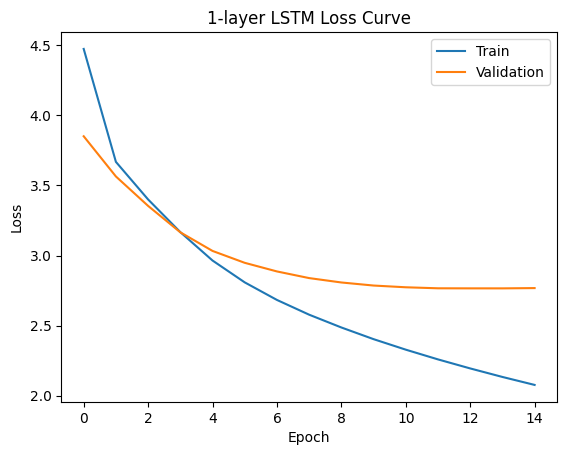

In [21]:
plt.plot(history_lstm_1.history['loss'])
plt.plot(history_lstm_1.history['val_loss'])
plt.title('1-layer LSTM Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

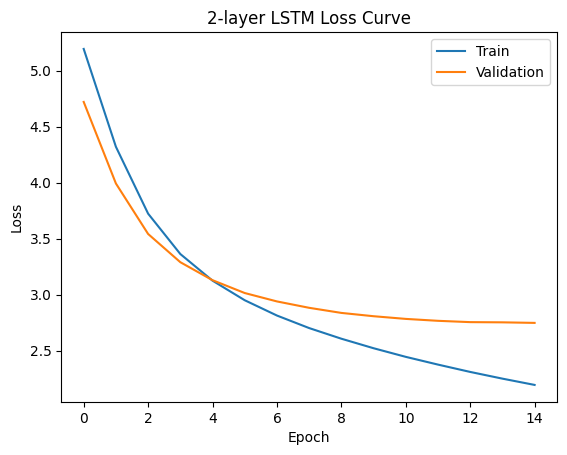

In [22]:
plt.plot(history_lstm_2.history['loss'])
plt.plot(history_lstm_2.history['val_loss'])
plt.title('2-layer LSTM Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

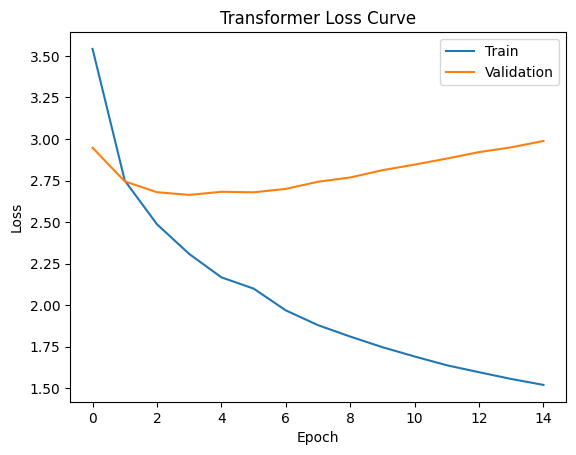

In [23]:
plt.plot(history_tf.history['loss'])
plt.plot(history_tf.history['val_loss'])
plt.title('Transformer Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Evaluation

In [ ]:
start_token_id = tokenizer.word_index['startseq']
end_token_id   = tokenizer.word_index['endseq']

index_word = {i: w for w, i in tokenizer.word_index.items()}

max_len = cap_padded.shape[1]

In [ ]:
def generate_caption(model, image_path, tokenizer, start_token_id, end_token_id):
    
    decoder_max_len = model.inputs[1].shape[1]
    decoder_max_len = int(decoder_max_len)   # TensorShape → int

    img = load_image(image_path)
    img = tf.expand_dims(img, 0)  # (1, H, W, 3)

    # init sequence
    seq = [start_token_id]

    for _ in range(decoder_max_len - 1):
        seq_pad = pad_sequences([seq], maxlen=decoder_max_len, padding='post')

        preds = model.predict([img, seq_pad], verbose=0)
        next_logits = preds[0, len(seq)-1]
        next_id = int(np.argmax(next_logits))

        if next_id in (end_token_id, 0):
            break

        seq.append(next_id)

    # to word
    words = []
    for idx in seq:
        if idx in (start_token_id, end_token_id, 0):
            continue
        w = index_word.get(idx)
        if w:
            words.append(w)

    return " ".join(words)


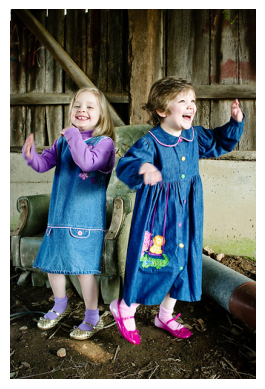

Image: 3427023324_f1f6504bf4.jpg
Ground Truth captions:
  GT 1: Two girls in blue dresses dance .
  GT 2: Two girls in jean dresses laugh and play .
  GT 3: Two little girls are smiling in blue dresses .
  GT 4: Two little girls in blue dresses laugh .
  GT 5: Two young girls wearing denim dresses playing near a armchair .

Model outputs:
  1-layer LSTM : two girls in a blue and yellow dress are playing in a sprinkler
  2-layer LSTM : two young girls are playing in a park
  Transformer  : two little girls in green boots playing with a toy

------------------------------------------------------------



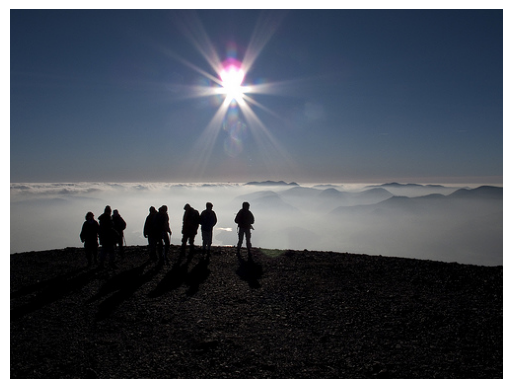

Image: 3215847501_c723905ba4.jpg
Ground Truth captions:
  GT 1: A group of climbers in silhouette stare towards the sun over the mountaintops .
  GT 2: A group of hikers looks at the tops of mountains .
  GT 3: Eight people are standing on a hill above the clouds .
  GT 4: Several people are standing on a ledge overlooking snowy mountains .
  GT 5: a group of people standing on a hill with the sun in the distance .

Model outputs:
  1-layer LSTM : a man and a dog are standing in the snow
  2-layer LSTM : a man stands on the edge of a mountain
  Transformer  : a group of hikers looks at the tops of mountains

------------------------------------------------------------



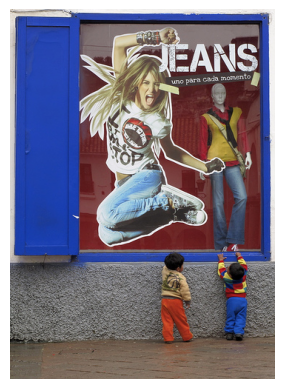

Image: 3419197575_aa5b84a9f0.jpg
Ground Truth captions:
  GT 1: The two kids are looking at a sign .
  GT 2: Two children looking up at a large fashion advertisement on a concrete wall .
  GT 3: Two small children stand next to a window display .
  GT 4: two little boys admire a shop window .
  GT 5: two small children standing next to a jeans advertisement .

Model outputs:
  1-layer LSTM : two young girls are sitting in a doorway
  2-layer LSTM : two young children are walking down a street
  Transformer  : two little kids stand around a sign

------------------------------------------------------------



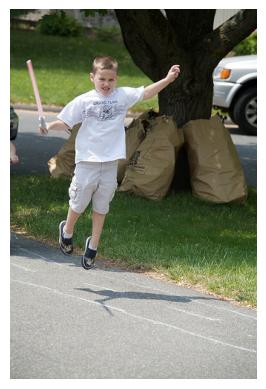

Image: 3568065409_1c381aa854.jpg
Ground Truth captions:
  GT 1: A boy holding a lightsaber jumps in the middle of the street .
  GT 2: A boy holding a stick jumping Ont he street .
  GT 3: A small boy in a white shirt is jumping with a sword in his hand .
  GT 4: A young boy jumps in the street while holding a stick .
  GT 5: a boy in shorts and white shirt is jumping whilst holding a pink stick in front of a large tree surrounded by sacks .

Model outputs:
  1-layer LSTM : a small boy in a red shirt is walking on the sidewalk
  2-layer LSTM : a boy in a blue shirt is running on the sidewalk
  Transformer  : a young boy in a white shirt and blue jeans is holding a sword

------------------------------------------------------------



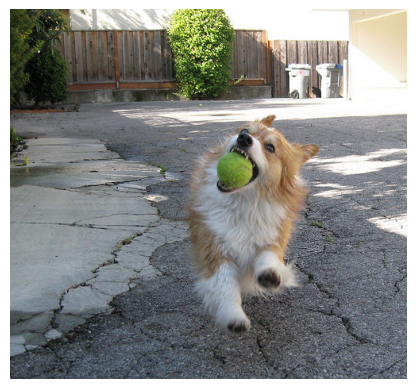

Image: 2830880811_d7f66dd2cf.jpg
Ground Truth captions:
  GT 1: A dog catches a tennis ball .
  GT 2: A dog is running while catching a tennis ball in its mouth .
  GT 3: A small dog with a tennis ball in its mouth playing in a driveway .
  GT 4: The tan and white dog is running outside with a tennis ball in its mouth .
  GT 5: a small dog catches a tennis ball in its mouth .

Model outputs:
  1-layer LSTM : a small white dog with a red collar is running on a gravel path
  2-layer LSTM : a dog is playing with a toy
  Transformer  : a dog is running up a driveway with a tennis ball in its mouth

------------------------------------------------------------



In [ ]:
# 5 validation images
num_samples = 5
idxs = np.random.choice(len(img_val), num_samples, replace=False)

for i in idxs:
    img_path = img_val[i]
    file_name = os.path.basename(img_path)

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("Image:", file_name)

    # Ground Truth captions
    gts = df[df['image'] == file_name]['caption'].tolist()
    print("Ground Truth captions:")
    for j, c in enumerate(gts):
        print(f"  GT {j+1}: {c}")

    # three caption
    cap_lstm_1 = generate_caption(model_lstm_1, img_path, tokenizer, start_token_id, end_token_id)
    cap_lstm_2 = generate_caption(model_lstm_2, img_path, tokenizer, start_token_id, end_token_id)
    cap_tf     = generate_caption(model_tf,     img_path, tokenizer, start_token_id, end_token_id)

    print("\nModel outputs:")
    print("  1-layer LSTM :", cap_lstm_1)
    print("  2-layer LSTM :", cap_lstm_2)
    print("  Transformer  :", cap_tf)
    print("\n" + "-"*60 + "\n")


In [ ]:
def build_eval_dicts(model, img_paths_subset, df, tokenizer, max_len, start_token_id, end_token_id):
    gts = defaultdict(list)
    res = defaultdict(list)

    for path in img_paths_subset:
        img_id = os.path.basename(path)

        # Ground truth captions, here is clean text
        gt_caps = df[df['image'] == img_id]['clean_caption'].tolist()
        for c in gt_caps:
            gts[img_id].append({'caption': c})

        # Model predicted caption
        pred = generate_caption(model, path, tokenizer, start_token_id, end_token_id)
        res[img_id].append({'caption': pred})

    return gts, res


In [ ]:
def build_eval_dicts(model, img_paths_subset, df, tokenizer, start_token_id, end_token_id):
    """
    progress 
    gts[img_id] = [{'caption': '...'}, ...]
    res[img_id] = [{'caption': 'model caption'}]
    """
    gts = defaultdict(list)
    res = defaultdict(list)

    for path in tqdm(img_paths_subset, desc="Building eval dicts"):
        img_id = os.path.basename(path)

        # Ground truth captions, here is clean text
        gt_caps = df[df['image'] == img_id]['clean_caption'].tolist()
        for c in gt_caps:
            gts[img_id].append({'caption': c})

        pred = generate_caption(model, path, tokenizer, start_token_id, end_token_id)
        res[img_id].append({'caption': pred})

    return gts, res

# def build_eval_dicts(model, img_paths_subset, df, tokenizer, start_token_id, end_token_id):
#     gts = defaultdict(list)
#     res = defaultdict(list)

#     for path in tqdm(img_paths_subset, desc="Building eval dicts"):
#         img_id = os.path.basename(path)

#         # Ground Truth captions
#         gt_caps = df[df['image'] == img_id]['clean_caption'].tolist()
#         for c in gt_caps:
#             gts[img_id].append(c)

#         # Model prediction
#         pred = generate_caption(model, path, tokenizer, start_token_id, end_token_id)
#         res[img_id].append(pred)

#     return gts, res

In [42]:
num_eval = min(300, len(img_val))
eval_img_paths = img_val[:num_eval]

gts_tf, res_tf = build_eval_dicts(
    model_tf,
    eval_img_paths,
    df,
    tokenizer,
    start_token_id,
    end_token_id
)


Building eval dicts: 100%|██████████| 300/300 [04:20<00:00,  1.15it/s]


In [43]:
gts_lstm1, res_lstm1 = build_eval_dicts(model_lstm_1, eval_img_paths, df, tokenizer, start_token_id, end_token_id)


Building eval dicts: 100%|██████████| 300/300 [04:51<00:00,  1.03it/s]


In [44]:
gts_lstm2, res_lstm2 = build_eval_dicts(model_lstm_2, eval_img_paths, df, tokenizer, start_token_id, end_token_id)


Building eval dicts: 100%|██████████| 300/300 [04:40<00:00,  1.07it/s]


In [ ]:
def evaluation_metrics(gts, res):
    scores = {}

    # BLEU-1 ~ BLEU-4
    bleu_scorer = Bleu(4)
    bleu_score, _ = bleu_scorer.compute_score(gts, res)
    scores['BLEU-1'] = bleu_score[0]
    scores['BLEU-2'] = bleu_score[1]
    scores['BLEU-3'] = bleu_score[2]
    scores['BLEU-4'] = bleu_score[3]

    # METEOR
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(gts, res)
    scores['METEOR'] = meteor_score

    # CIDEr
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(gts, res)
    scores['CIDEr'] = cider_score

    return scores


In [ ]:
def fix_dict_to_strings(gts_or_res):
    fixed = {}
    for img_id, caps in gts_or_res.items():
        # caps: [{'caption': "..."}]
        fixed[img_id] = [ c['caption'] if isinstance(c, dict) else c for c in caps ]
    return fixed

In [ ]:
# if we use mutil-pred, there is error happens when evaluation ?? 
def squash_res_to_single_pred(res_dict):
    single = {}
    for img_id, caps in res_dict.items():
        if not caps:
            continue
        # keep one prediction to avoid array
        single[img_id] = [caps[0]]
    return single

In [54]:
# gts[img_id] = [{'caption': "..."}]
# res[img_id] = [{'caption': "..."}]

gts_lstm1_fixed = fix_dict_to_strings(gts_lstm1)
res_lstm1_fixed = fix_dict_to_strings(res_lstm1)

gts_lstm2_fixed = fix_dict_to_strings(gts_lstm2)
res_lstm2_fixed = fix_dict_to_strings(res_lstm2)

gts_tf_fixed    = fix_dict_to_strings(gts_tf)
res_tf_fixed    = fix_dict_to_strings(res_tf)

In [56]:
res_lstm1_single = squash_res_to_single_pred(res_lstm1_fixed)
res_lstm2_single = squash_res_to_single_pred(res_lstm2_fixed)
res_tf_single    = squash_res_to_single_pred(res_tf_fixed)

In [ ]:
scores_tf    = evaluation_metrics(gts_tf_fixed,    res_tf_single)
print("Transformer scores:", scores_tf)

{'testlen': 3098, 'reflen': 3053, 'guess': [3098, 2801, 2504, 2207], 'correct': [2325, 1366, 728, 402]}
ratio: 1.0147396003927236
Transformer scores: {'BLEU-1': 0.7504841833438507, 'BLEU-2': 0.6049779795554507, 'BLEU-3': 0.47386947043666605, 'BLEU-4': 0.37312124447788414, 'METEOR': 0.2995727566239486, 'CIDEr': 1.139031988018385}


In [ ]:
scores_lstm1 = evaluation_metrics(gts_lstm1_fixed, res_lstm1_single)
print("1-layer LSTM scores:", scores_lstm1)

{'testlen': 3347, 'reflen': 3171, 'guess': [3347, 3050, 2753, 2456], 'correct': [1900, 790, 275, 97]}
ratio: 1.055502995900014
1-layer LSTM scores: {'BLEU-1': 0.5676725425752711, 'BLEU-2': 0.3834533800010144, 'BLEU-3': 0.24489723080056633, 'BLEU-4': 0.15519357898479016, 'METEOR': 0.18542460798354227, 'CIDEr': 0.3737590615211965}


In [ ]:
scores_lstm2 = evaluation_metrics(gts_lstm2_fixed, res_lstm2_single)
print("2-layer LSTM scores:", scores_lstm2)

{'testlen': 3194, 'reflen': 3109, 'guess': [3194, 2897, 2600, 2303], 'correct': [1984, 888, 327, 136]}
ratio: 1.0273399807008596
2-layer LSTM scores: {'BLEU-1': 0.6211646837818969, 'BLEU-2': 0.4363506359888039, 'BLEU-3': 0.2882362133973736, 'BLEU-4': 0.19392002140387266, 'METEOR': 0.20185698010130496, 'CIDEr': 0.4916254006324335}


| Model              | BLEU-1 | BLEU-2 | BLEU-3 | BLEU-4 | METEOR | CIDEr |
|--------------------|--------|--------|--------|--------|--------|-------|
| 1-layer LSTM       | 0.568  | 0.383  | 0.245  | 0.155  | 0.185  | 0.374 |
| 2-layer LSTM       | 0.621  | 0.436  | 0.288  | 0.194  | 0.202  | 0.492 |
| Transformer Decoder| 0.750  | 0.605  | 0.474  | 0.373  | 0.300  | 1.139 |

# Analysis
The results show that the Transformer achieves higher scores than the LSTM models, reflecting stronger language generation and accuracy. 
However, its rising validation loss suggests overfitting, implying that a larger dataset would help it generalize better.


# Conclusion
In this project, I compared three fundamental image captioning models using a shared EfficientNetB0 encoder and three different decoders: a 1-layer LSTM, a 2-layer LSTM, and a Transformer decoder.  
Based on the loss curves and evaluation metrics including BLEU, METEOR, and CIDEr, the model capacity shows a clear impact on caption quality.  
For small-scale datasets such as Flickr8k, the 2-layer LSTM achieves the best balance between stability and performance. Although the Transformer decoder obtains the highest language scores, it exhibits noticeable overfitting due to limited data. With a larger dataset, the Transformer architecture is expected to outperform the LSTM models more reliably.


# Future work
- Using a larger dataset could help reduce overfitting in the Transformer decoder and allow it to fully realize its modeling capacity.
- Analyzing or visualizing cross-attention maps may provide insights into how the model aligns image regions with generated words, potentially guiding further architecture improvements.
- Incorporating pre-trained word embeddings such as GloVe or FastText may enhance the semantic quality of generated captions, especially when training data is limited.
- Experimenting with advanced techniques like reinforcement learning or beam search during inference to improve caption quality and diversity.
- Try more Hyperparameter Tuning:
    - Learning rate: {1e-3, 5e-4, 1e-4}
    - Batch size: {32, 64, 128} 
    - Dropout: {0.1, 0.2, 0.3}


# Reference
- A survey on image captioning methods
- Show and Tell: A Neural Image Caption Generator
- Comparative study of Transformer and LSTM Network with attention mechanism on Image Captioning
- Image Captioning based on Deep Learning Methods: A Survey
- From Show to Tell: A Survey on Deep Learning-based Image Captioning
